### 一.简介
xgboost在集成学习中占有重要的一席之位，通常在各大竞赛中作为杀器使用，同时它在工业落地上也很方便，目前针对大数据领域也有各种分布式实现版本，比如xgboost4j-spark,xgboost4j-flink等。xgboost的基础也是gbm，即梯度提升模型，它在此基础上做了进一步优化...

### 二.损失函数：引入二阶项
xgboost的损失函数构成如下，即一个经验损失项+正则损失项：   

$$
Cost(y,F_{m-1},f_m)=\sum_{i=1}^n L(y_i,F_{m-1}(x_i)+f_m(x_i))+\Omega(f_m)
$$   

这里$n$表示样本数，$F_{m-1}$表示前$m-1$轮模型，$f_m$表示第$m$轮新训练模型，所以$F_m=F_{m-1}+f_m$，$\Omega(f_m)$是对第$m$轮新训练模型进行约束的正则化项，在前面第6小节做过探索，对损失函数近似做二阶泰勒展开，并对近似损失函数做优化，通常会收敛的更快更好，接下里看下对第$i$个样本的经验项损失函数做二阶展开：   

$$
L(y_i,F_{m-1}(x_i)+f_m(x_i))=L(y_i,F_{m-1}(x_i))+g_if_m(x_i)+\frac{1}{2}h_if_m^2(x_i)
$$   

这里：   

$$
g_i=\frac{\partial L(y_i,F_{m-1}(x_i))}{\partial F_{m-1}(x_i)}\\
h_i=\frac{\partial^2 L(y_i,F_{m-1}(x_i))}{\partial {F_{m-1}(x_i)}^2}
$$    

对于第$m$轮，$L(y_i,F_{m-1}(x_i))$为常数项，不影响优化，可以省略掉，所以损失函数可以表示为如下：   

$$
Cost(y,F_{m-1},f_m)=\sum_{i=1}^n [g_if_m(x_i)+\frac{1}{2}h_if_m^2(x_i)]+\Omega(f_m)
$$   

这便是xgboost的学习框架，针对不同问题，比如回归、分类、排序，会有不同的$L(\cdot)$以及$\Omega(\cdot)$，另外由于需要二阶信息，所以$L(\cdot)$必须要能二阶可微，接下来对基学习器为决策树的情况做推导

### 三.基学习器：回归决策树
下面推导一下基学习器为回归树的情况，当选择决策树时，它的正则化项如下：   

$$
\Omega(f_m)=\gamma T+\frac{1}{2}\lambda\sum_{j=1}^T\omega_j^2
$$  

其中，$j=1,2,...,T$表达对应的叶节点编号，$\omega_j$表示落在第$j$个叶节点的样本的预测值，即：   

$$
\omega_j=f_m(x_i),x_i\in I_j
$$  

$I_j$表示第$j$个叶子节点所属区域，所以决策树的损失函数可以改写为如下：  

$$
Cost(y,F_{m-1},f_m)=\sum_{j=1}^T[(\sum_{i\in I_j}g_i)\omega_j+\frac{1}{2}(\sum_{i\in I_j}h_i+\lambda)\omega_j^2]+\gamma T
$$  

这其实是关于$\omega$的一元二次函数，直接写出它的最优解：   

$$
\omega_j^*=-\frac{G_j}{H_j+\lambda}
$$  

这里$G_j=\sum_{i\in I_j}g_i,H_j=\sum_{i\in I_j}h_i$,可见$L_2$正则项起到了缩小叶子节点权重的效果，减少其对整个预测结果的影响，从而防止过拟合，将$\omega_j^*$带入可得损失值：   

$$
Cost(y,F_{m-1},f_m^*)=-\frac{1}{2}\sum_{j=1}^T\frac{G_j^2}{H_j+\lambda}+\gamma T
$$   


#### 特征选择

很显然，上面的损失函数可以直接用于特征选择中，对某节点在分裂前的评分为：  

$$
Score_{pre}=-\frac{1}{2}\frac{G^2}{H+\lambda}+\gamma
$$  

分裂后，左右子节点的评分和为：  

$$
Score_{pre}=-\frac{1}{2}(\frac{G_L^2}{H_L+\lambda}+\frac{G_R^2}{H_R+\lambda})+2\gamma
$$  

所以分裂所能带来的增益：  

$$
Score=\frac{1}{2}[\frac{G_L^2}{H_L+\lambda}+\frac{G_R^2}{H_R+\lambda}-\frac{G^2}{H+\lambda}]-\gamma
$$  

这里$G=G_L+G_R,H=H_L+H_R$   

### 四.代码实现

这部分对xgboost中的回归树做简单实现，大体流程其实与CART回归树差不多，下面说下它与CART回归树不一样的几个点：   

（1）这里`fit`与之前的CART回归树有些不一样了，之前是`fit(x,y)`，而现在需要`fit(x,g,h)`；  

（2）特征选择不一样了，之前是求平方误差的增益，现在需要利用一阶和二阶导数信息，见上面的$Score$   

（3）叶子节点的预测值不一样了，之前是求均值，现在需利用一阶和二阶导数信息，见上面的$w_j^*$  

接下来对xgboost所需要用到的回归树做简单实现

In [1]:
import os
os.chdir('../')
import numpy as np
from ml_models.wrapper_models import DataBinWrapper

"""
xgboost基模型：回归树的实现，封装到ml_models.ensemble
"""

class XGBoostBaseTree(object):
    class Node(object):
        """
        树节点，用于存储节点信息以及关联子节点
        """

        def __init__(self, feature_index: int = None, feature_value=None, y_hat=None, score=None,
                     left_child_node=None, right_child_node=None, num_sample: int = None):
            """
            :param feature_index: 特征id
            :param feature_value: 特征取值
            :param y_hat: 预测值
            :param score: 损失函数值
            :param left_child_node: 左孩子结点
            :param right_child_node: 右孩子结点
            :param num_sample:样本量
            """
            self.feature_index = feature_index
            self.feature_value = feature_value
            self.y_hat = y_hat
            self.score = score
            self.left_child_node = left_child_node
            self.right_child_node = right_child_node
            self.num_sample = num_sample

    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1, gamma=1e-2, lamb=1e-1,
                 max_bins=10):
        """
        :param max_depth:树的最大深度
        :param min_samples_split:当对一个内部结点划分时，要求该结点上的最小样本数，默认为2
        :param min_samples_leaf:设置叶子结点上的最小样本数，默认为1
        :param gamma:即损失函数中的gamma
        :param lamb:即损失函数中lambda
        """
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.gamma = gamma
        self.lamb = lamb

        self.root_node: self.Node = None
        self.dbw = DataBinWrapper(max_bins=max_bins)

    def _score(self, g, h):
        """
        计算损失损失评分
        :param g:一阶导数
        :param h: 二阶导数
        :return:
        """
        G = np.sum(g)
        H = np.sum(h)
        return -0.5 * G ** 2 / (H + self.lamb) + self.gamma

    def _build_tree(self, current_depth, current_node: Node, x, g, h):
        """
        递归进行特征选择，构建树
        :param x:
        :param y:
        :param sample_weight:
        :return:
        """
        rows, cols = x.shape
        # 计算G和H
        G = np.sum(g)
        H = np.sum(h)
        # 计算当前的预测值
        current_node.y_hat = -1 * G / (H + self.lamb)
        current_node.num_sample = rows
        # 判断停止切分的条件
        current_node.score = self._score(g, h)

        if rows < self.min_samples_split:
            return

        if self.max_depth is not None and current_depth > self.max_depth:
            return

        # 寻找最佳的特征以及取值
        best_index = None
        best_index_value = None
        best_criterion_value = 0
        for index in range(0, cols):
            for index_value in sorted(set(x[:, index])):
                left_indices = np.where(x[:, index] <= index_value)
                right_indices = np.where(x[:, index] > index_value)
                criterion_value = current_node.score - self._score(g[left_indices], h[left_indices]) - self._score(
                    g[right_indices], h[right_indices])
                if criterion_value > best_criterion_value:
                    best_criterion_value = criterion_value
                    best_index = index
                    best_index_value = index_value

        # 如果减少不够则停止
        if best_index is None:
            return
        # 切分
        current_node.feature_index = best_index
        current_node.feature_value = best_index_value
        selected_x = x[:, best_index]

        # 创建左孩子结点
        left_selected_index = np.where(selected_x <= best_index_value)
        # 如果切分后的点太少，以至于都不能做叶子节点，则停止分割
        if len(left_selected_index[0]) >= self.min_samples_leaf:
            left_child_node = self.Node()
            current_node.left_child_node = left_child_node
            self._build_tree(current_depth + 1, left_child_node, x[left_selected_index], g[left_selected_index],
                             h[left_selected_index])
        # 创建右孩子结点
        right_selected_index = np.where(selected_x > best_index_value)
        # 如果切分后的点太少，以至于都不能做叶子节点，则停止分割
        if len(right_selected_index[0]) >= self.min_samples_leaf:
            right_child_node = self.Node()
            current_node.right_child_node = right_child_node
            self._build_tree(current_depth + 1, right_child_node, x[right_selected_index], g[right_selected_index],
                             h[right_selected_index])

    def fit(self, x, g, h):
        # 构建空的根节点
        self.root_node = self.Node()

        # 对x分箱
        self.dbw.fit(x)

        # 递归构建树
        self._build_tree(1, self.root_node, self.dbw.transform(x), g, h)

    # 检索叶子节点的结果
    def _search_node(self, current_node: Node, x):
        if current_node.left_child_node is not None and x[current_node.feature_index] <= current_node.feature_value:
            return self._search_node(current_node.left_child_node, x)
        elif current_node.right_child_node is not None and x[current_node.feature_index] > current_node.feature_value:
            return self._search_node(current_node.right_child_node, x)
        else:
            return current_node.y_hat

    def predict(self, x):
        # 计算结果
        x = self.dbw.transform(x)
        rows = x.shape[0]
        results = []
        for row in range(0, rows):
            results.append(self._search_node(self.root_node, x[row]))
        return np.asarray(results)


下面简单测试一下功能，假设$F_0(x)=0$，损失函数为平方误差的情况，则其一阶导为$g=F_0(x)-y=-y$，二阶导为$h=1$

In [2]:
#构造数据
data = np.linspace(1, 10, num=100)
target1 = 3*data[:50] + np.random.random(size=50)*3#添加噪声
target2 = 3*data[50:] + np.random.random(size=50)*10#添加噪声
target=np.concatenate([target1,target2])
data = data.reshape((-1, 1))

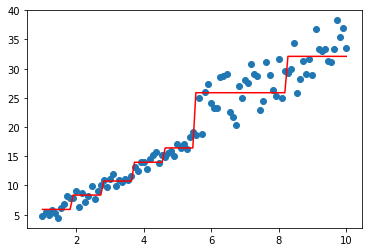

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
model=XGBoostBaseTree(lamb=0.1,gamma=0.1)
model.fit(data,-1*target,np.ones_like(target))
plt.scatter(data, target)
plt.plot(data, model.predict(data), color='r')

分别看看lambda和gamma的效果

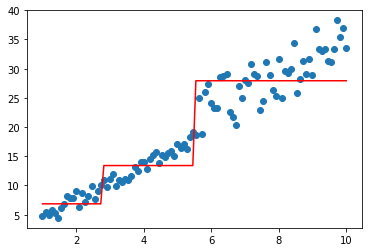

In [4]:
model=XGBoostBaseTree(lamb=1,gamma=0.1)
model.fit(data,-1*target,np.ones_like(target))
plt.scatter(data, target)
plt.plot(data, model.predict(data), color='r')

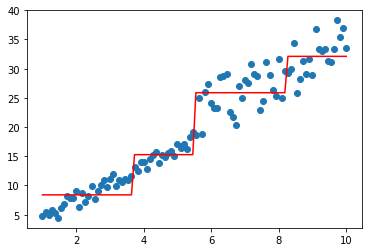

In [5]:
model=XGBoostBaseTree(lamb=0.1,gamma=100)
model.fit(data,-1*target,np.ones_like(target))
plt.scatter(data, target)
plt.plot(data, model.predict(data), color='r')